# Lab 2

Вам потрібно згенерувати обраний дескриптор для обраного предмета, після чого з його допомогою розпізнати об’єкт на всій тестовій вибірці збираючи при цьому такі метрики: відносна кількість правильно суміщених ознак, похибка локалізації (відстань між реальним розміщенням предмета в кадрі та розпізнаним) та відносний час обробки фото в залежності від розміру зображення. Метрики мають зберегтись у файлику для подальших досліджень. 

Наступним кроком ви обмінюєтесь об’єктом з колегою, і уже маючи готову збиралку метрик, обчислюєте їх для предмета вашого сусіда.

Самою ж ідеєю лаби є дослідити розбіжності у роботі ваших дескрипторів та виконати порівняльний аналіз їх поведінки, сформулювати висновки з викладками і прикладами так аби було зрозуміло вам та, сподіваюсь, усім вашим колегам. Таким чином кінцевим результатом буде від вас **гуглдок з описом виняткових особливостей, сильних та слабких сторін дескриптора і обгрунтуванням чому вони поводяться саме так.**

In [1]:
import os
import cv2
import time
import numpy as np
import pandas as pd

from IPython.display import Image

In [2]:
def open_photos(path='photos',orig ='train.jpg', scale = 0.25):
    images = []
    names = os.listdir(path)
    names = list(filter(lambda x: str(x[-4:]) == ".jpg", names))
    names.sort(key = lambda x: int(x[:-4]))
    for filename in names:
        img = cv2.imread(os.path.join(path,filename), 0)
        if img is not None:
            img = cv2.resize(img, (0,0), fx=scale, fy=scale) 
            images.append(img) 
    
    image = cv2.imread(orig, 0)
    image = cv2.resize(image, (0,0), fx=scale, fy=scale)
    return images, names, image
    
test, names, train = open_photos()

In [3]:
def SIFT(train, test):
    
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(train, None)
    kp2, des2 = sift.detectAndCompute(test, None)
    
    return kp1, des1, kp2, des2
    
def match(train, test, method='sift', threshold=0.8, save = False):
    
    start = time.time()
    
    if method == 'sift': kp1, des1, kp2, des2 = SIFT(train, test)
    if method == 'asift': kp1, des1, kp2, des2 = ASIFT(train, test)
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    
    good = []
    for m, n in matches:
        if m.distance / n.distance <= threshold:
            good.append(m)
    
    if len(good) >= 10:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()
        
    else:
        print("Not enough matches are found - {}/{}".format(len(good),10))
        return -1, -1, time.time() - start
        
    t = time.time() - start
    
    if save: 
        draw_params = dict(matchColor = (0, 255, 0), singlePointColor = (255, 0, 0), matchesMask = matchesMask, flags = 2)
        result = cv2.drawMatches(train, kp1, test, kp2, good, None, **draw_params)
        cv2.imwrite('peow.jpg', result)
        
    m2 = 0
    for m in good:
        m2 += m.distance
        
    m2 = m2/len(good)   
    m1 = sum(matchesMask,) / len(matchesMask)
        
    return m1, m2, t

Wall time: 1.41 s


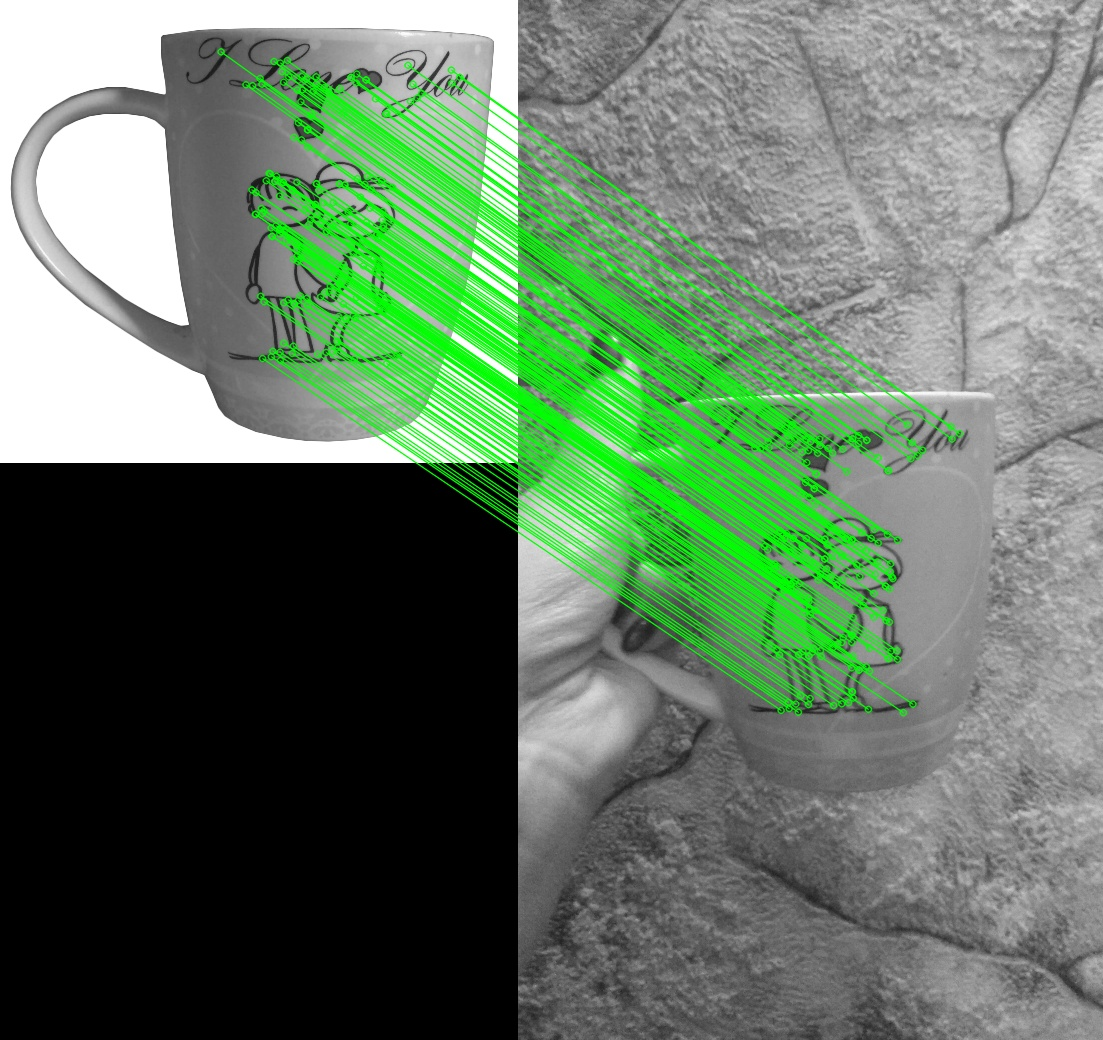

In [4]:
%%time
match(train, test[60], method='sift', threshold=0.8, save = True)
Image(filename='peow.jpg', width=400)

## Bonus! 
Короче я решила так же попробовать поработать с ASIFT.

В библиотеке его нет, но есть [код его использования в официальном гите opencv](https://github.com/opencv/opencv/blob/master/samples/python/asift.py).

На его авторство не претендую
и честно признаю, что функции просто взяла с него и изменила под себя (если так вдруг было нельзя). Мне было скорее сравнить результаты его работы со SIFT'ом, нежели практиковаться в его написании  

In [5]:
import itertools as it
it.imap = lambda *args, **kwargs: list(map(*args, **kwargs))

def affine_skew(tilt, phi, img, mask=None):
    '''
    affine_skew(tilt, phi, img, mask=None) -> skew_img, skew_mask, Ai
    Ai - is an affine transform matrix from skew_img to img
    '''
    h, w = img.shape[:2]
    if mask is None:
        mask = np.zeros((h, w), np.uint8)
        mask[:] = 255
    A = np.float32([[1, 0, 0], [0, 1, 0]])
    if phi != 0.0:
        phi = np.deg2rad(phi)
        s, c = np.sin(phi), np.cos(phi)
        A = np.float32([[c,-s], [ s, c]])
        corners = [[0, 0], [w, 0], [w, h], [0, h]]
        tcorners = np.int32( np.dot(corners, A.T) )
        x, y, w, h = cv2.boundingRect(tcorners.reshape(1,-1,2))
        A = np.hstack([A, [[-x], [-y]]])
        img = cv2.warpAffine(img, A, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    if tilt != 1.0:
        s = 0.8*np.sqrt(tilt*tilt-1)
        img = cv2.GaussianBlur(img, (0, 0), sigmaX=s, sigmaY=0.01)
        img = cv2.resize(img, (0, 0), fx=1.0/tilt, fy=1.0, interpolation=cv2.INTER_NEAREST)
        A[0] /= tilt
    if phi != 0.0 or tilt != 1.0:
        h, w = img.shape[:2]
        mask = cv2.warpAffine(mask, A, (w, h), flags=cv2.INTER_NEAREST)
    Ai = cv2.invertAffineTransform(A)
    return img, mask, Ai


def affine_detect(detector, img, mask=None, pool=None):
    '''
    affine_detect(detector, img, mask=None, pool=None) -> keypoints, descrs
    Apply a set of affine transformations to the image, detect keypoints and
    reproject them into initial image coordinates.
    ThreadPool object may be passed to speedup the computation.
    '''
    params = [(1.0, 0.0)]
    for t in 2**(0.5*np.arange(1,6)):
        for phi in np.arange(0, 180, 72.0 / t):
            params.append((t, phi))

    def f(p):
        t, phi = p
        timg, tmask, Ai = affine_skew(t, phi, img)
        keypoints, descrs = detector.detectAndCompute(timg, tmask)
        for kp in keypoints:
            x, y = kp.pt
            kp.pt = tuple( np.dot(Ai, (x, y, 1)) )
        if descrs is None:
            descrs = []
        return keypoints, descrs

    keypoints, descrs = [], []
    if pool is None:
        ires = it.imap(f, params)
    else:
        ires = pool.imap(f, params)

    for i, (k, d) in enumerate(ires):
        keypoints.extend(k)
        descrs.extend(d)

    return keypoints, np.array(descrs)

In [6]:
from multiprocessing.pool import ThreadPool

def ASIFT(train, test):
    
    sift = cv2.SIFT_create()
    pool=ThreadPool(4)
    kp1, des1 = affine_detect(sift, train, pool)
    kp2, des2 = affine_detect(sift, test, pool)
    pool.close()
    pool.join()
    
    return kp1, des1, kp2, des2

сравним результаты с "обычным" sift'ом:

Wall time: 1.36 s


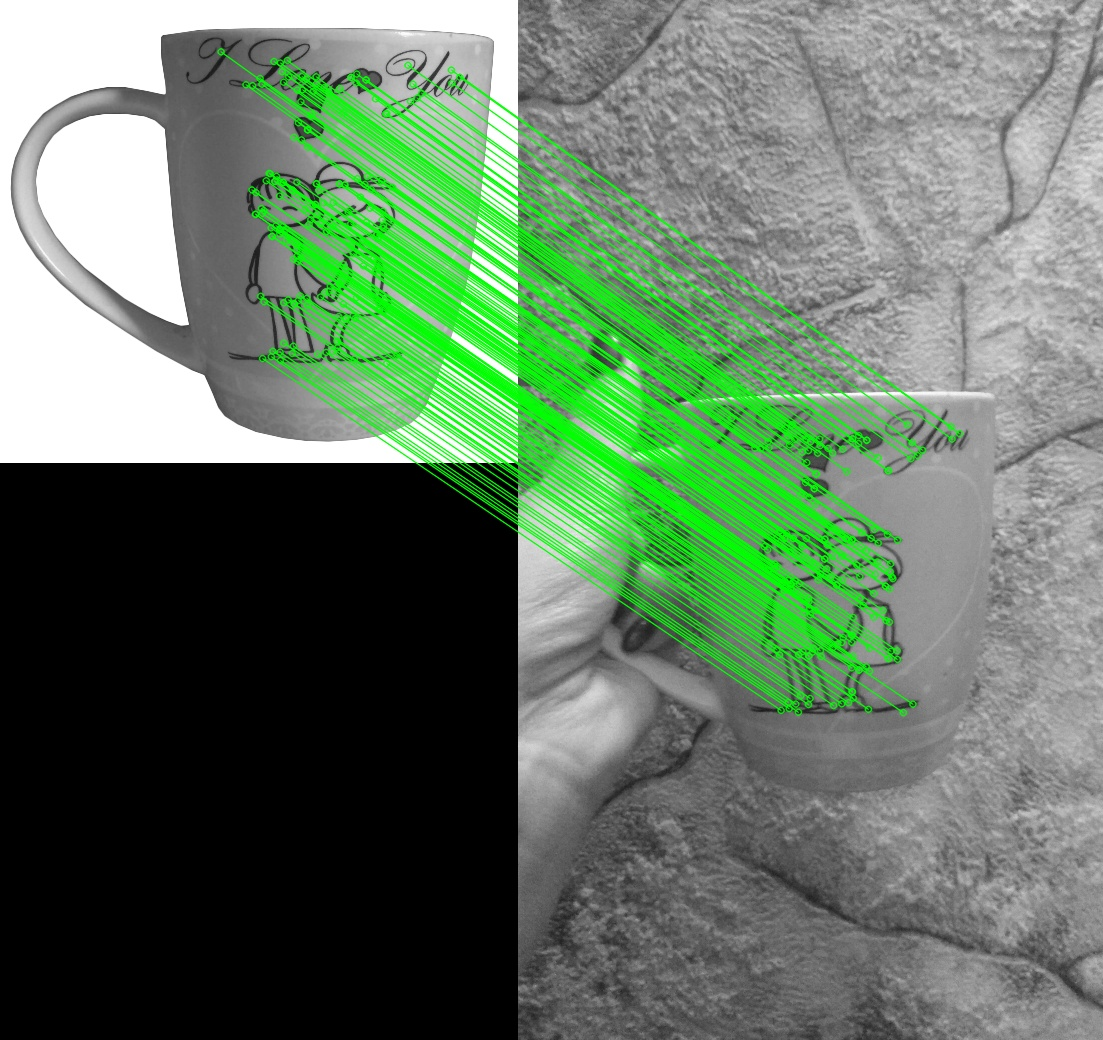

In [7]:
%%time
match(train, test[60], method='sift', threshold=0.8, save = True)
Image(filename='peow.jpg', width=300)

Wall time: 1min 22s


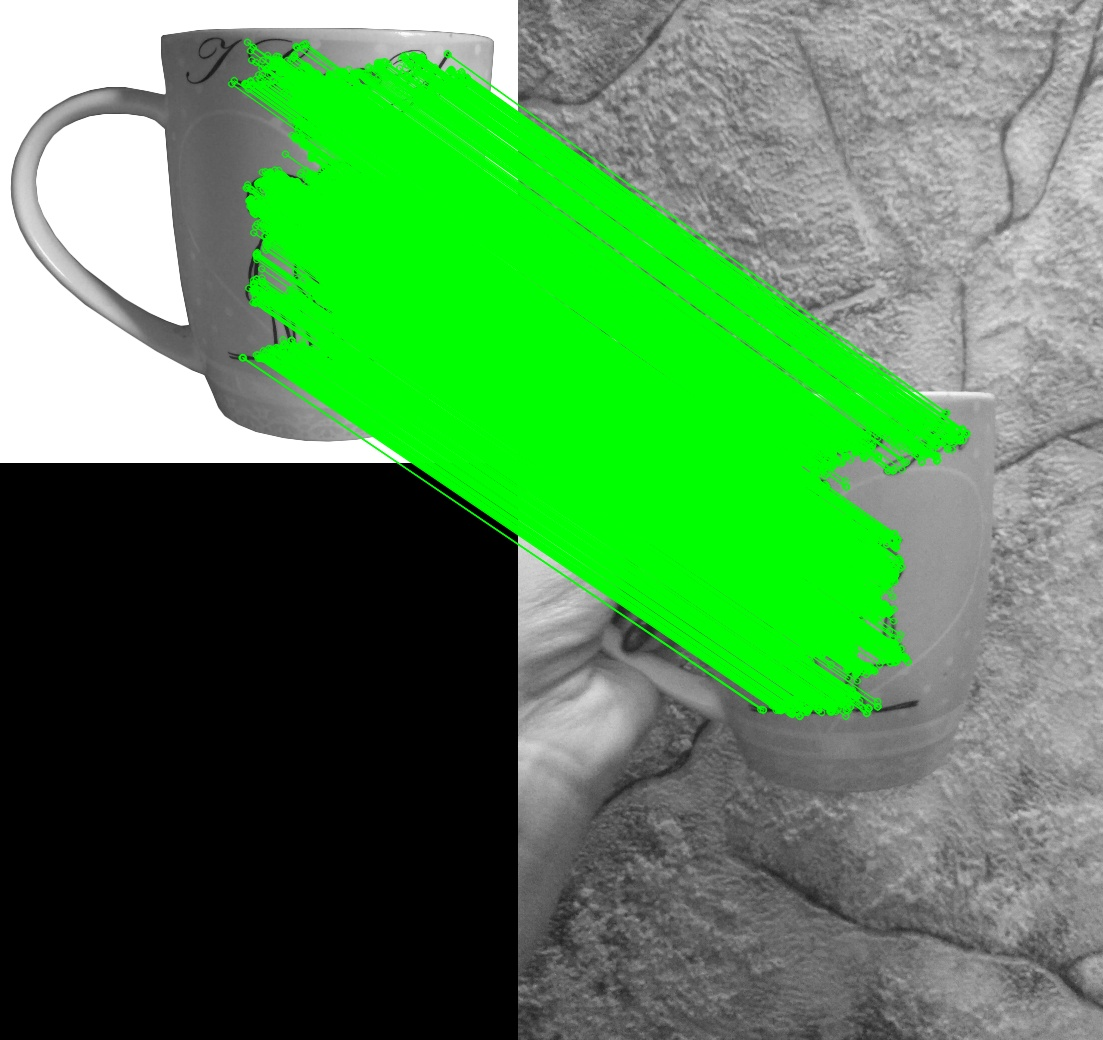

In [8]:
%%time
match(train, test[60], method='asift', threshold=0.8, save = True)
Image(filename='peow.jpg', width=300)

попробуем с "заваленной" фоткой

Wall time: 1.3 s


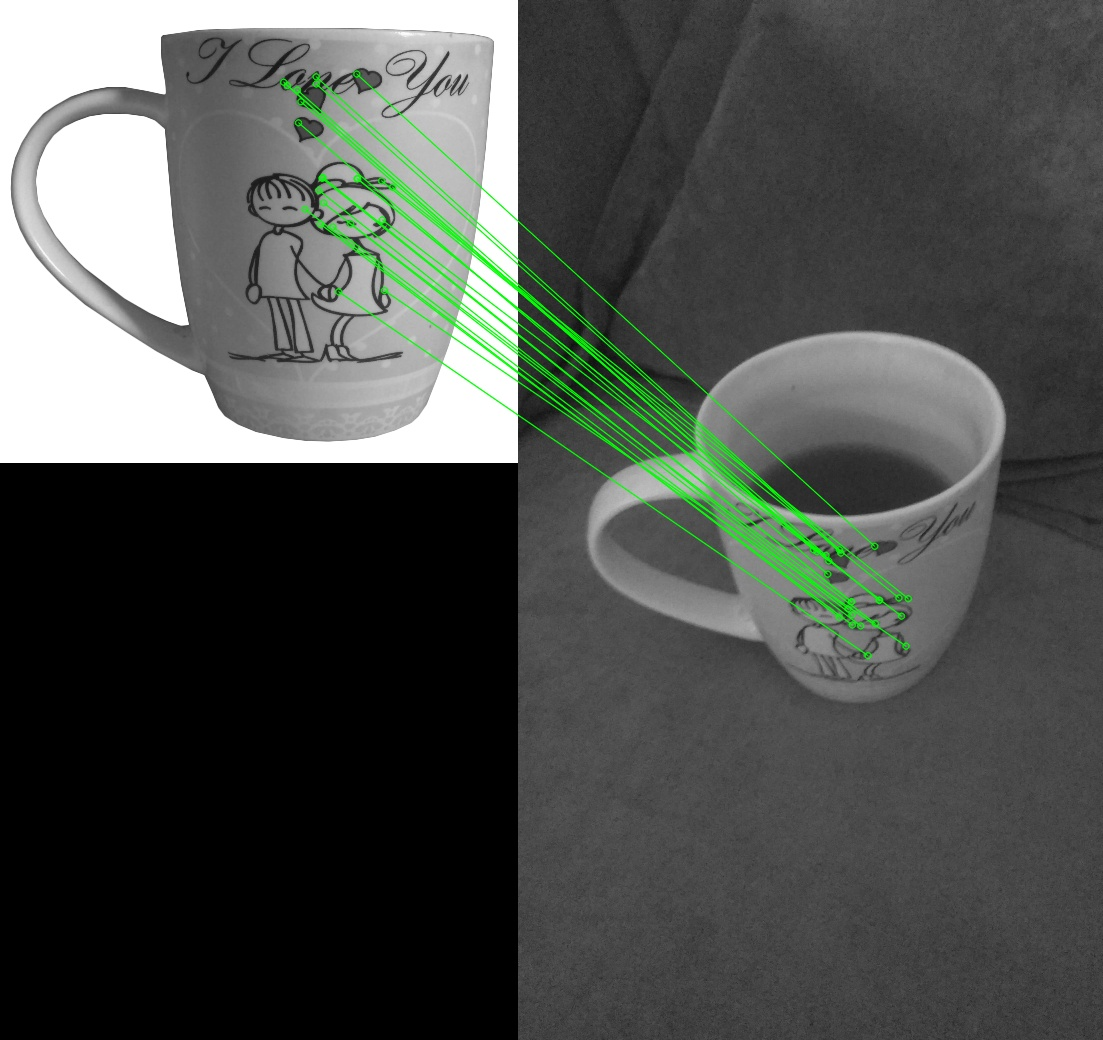

In [9]:
%%time
match(train, test[71], method='sift', threshold=0.8, save = True)
Image(filename='peow.jpg', width=300)

Wall time: 25 s


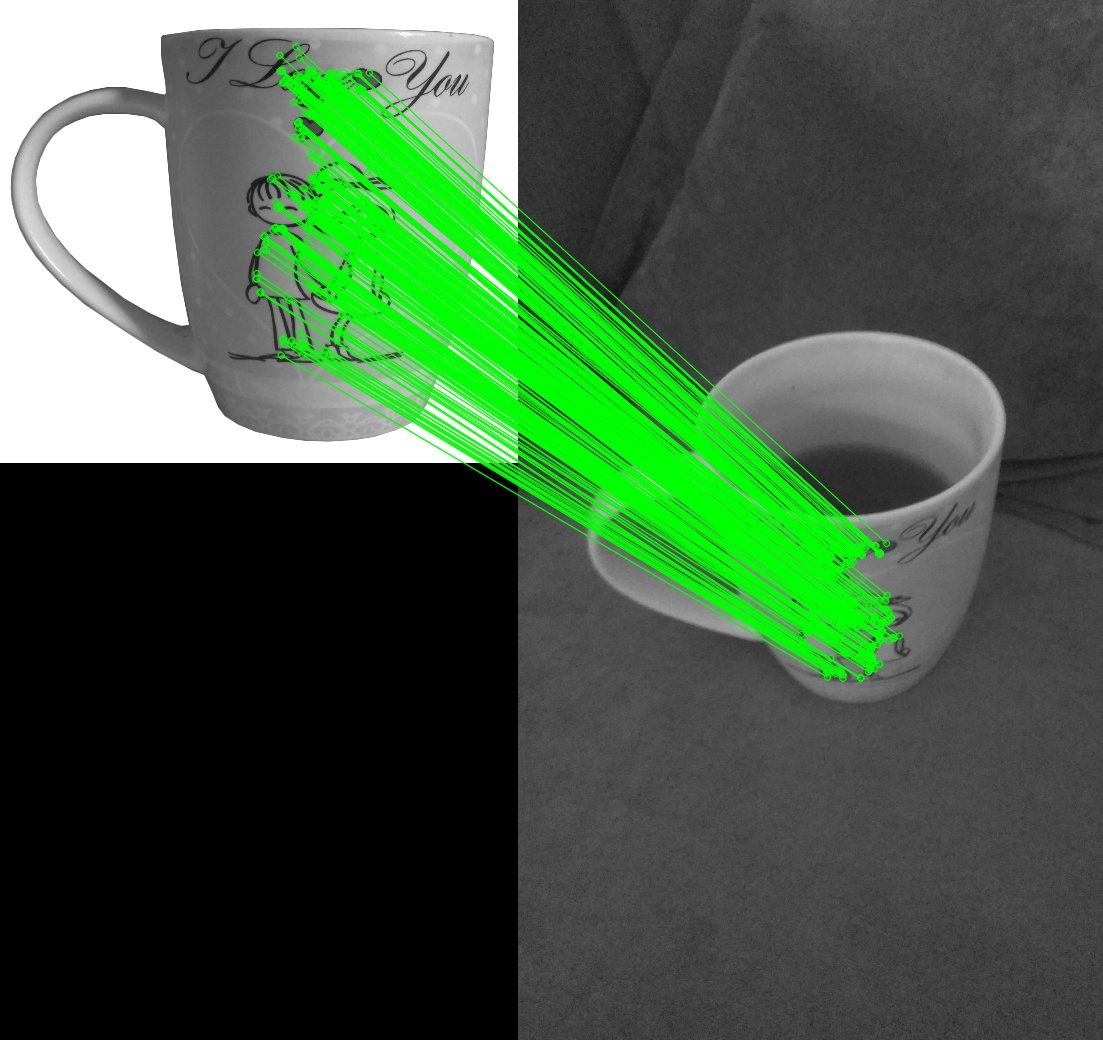

In [10]:
%%time
match(train, test[71], method='asift', threshold=0.8, save = True)
Image(filename='peow.jpg', width=300)

Wall time: 1.11 s


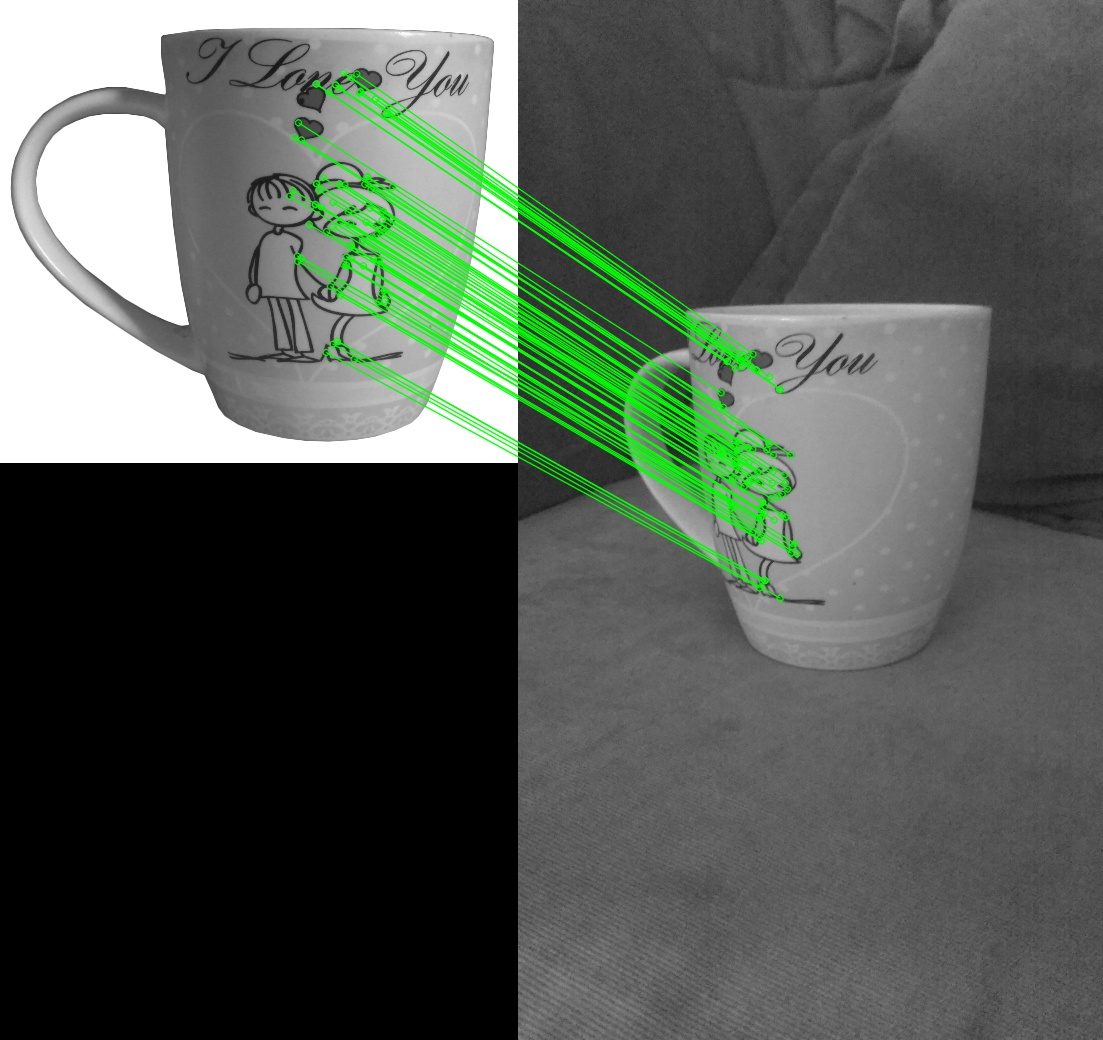

In [11]:
%%time
match(train, test[73], method='sift', threshold=0.8, save = True)
Image(filename='peow.jpg', width=300)

Wall time: 31 s


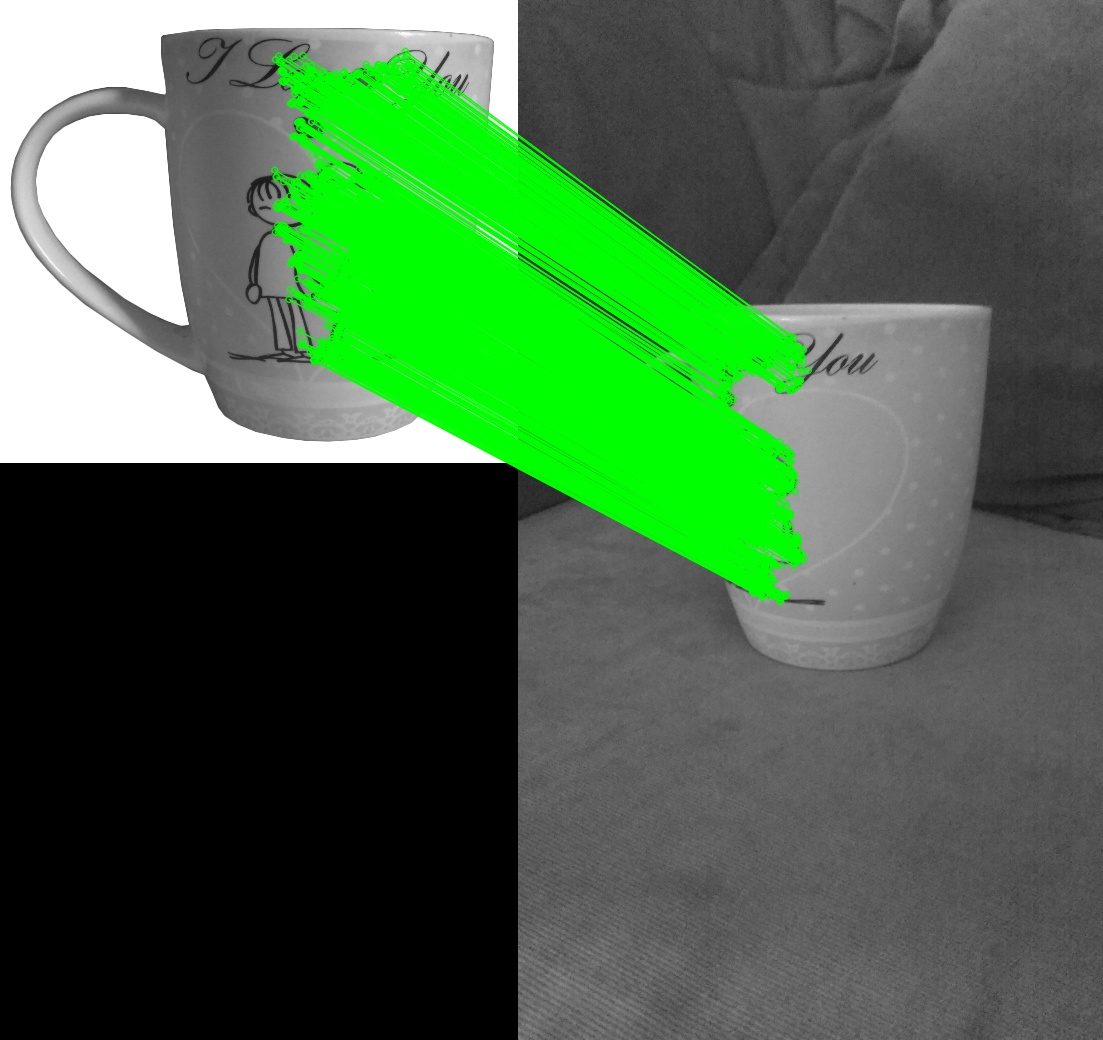

In [12]:
%%time
match(train, test[73], method='asift', threshold=0.8, save = True)
Image(filename='peow.jpg', width=300)

ну разве не прелесть? 

### Сделаем таблички

### SIFT

In [13]:
def get_data(scale = 0.25, scales = [], path="photos", orig='train.jpg', method = 'sift'):
    data = pd.DataFrame({"id":[], "m1":[], "m2":[],"size":[], "x" + str(scale):[]})
    test, names, train = open_photos(scale = scale, path = path, orig=orig)
    print(scale)
    for name, photo in zip(names, test):
        m1, m2, t = match(train, photo, method=method, threshold=0.8)
        print(name)
        data = data.append({"id":name[:-4], "m1":m1, "m2":m2,"size":photo.shape, "x" + str(scale):t}, ignore_index=True)
    for scale_ in scales:
        temp_l = []
        test, names, train = open_photos(scale=scale_, path=path, orig=orig)
        print(scale_)
        i = 0
        for photo in test:
            print(i)
            i+=1
            m1, m2, t = match(train, photo, method=method, threshold=0.8)
            temp_l.append(t)
        temp = pd.Series(temp_l, name= "x" + str(scale_))
        data["x" + str(scale_)] = temp
    return data

In [ ]:
scale = 0.25
scales = [0.2, 0.15]
data = get_data(scale, scales)

In [ ]:
data.head()

In [ ]:
data.to_csv('cup_sift.csv')

### ASIFT

In [ ]:
scale = 0.25
scales = [0.2, 0.15]
data = get_data(scale, scales, path='photos',orig='train.jpg', method='asift')

In [ ]:
data.head()

In [ ]:
data.to_csv('cup_asift.csv')

### SIFT & ASIFT для датасета моего сокамандника:

In [ ]:
scale = 0.25
scales = [0.2, 0.15]
data = get_data(scale, scales, path='photos_rus', orig='train_rus.jpg')

In [ ]:
data.to_csv('anticeptik_sift.csv')

In [ ]:
scale = 0.25
scales = [0.2, 0.15]
data = get_data(scale, scales, path='photos_rus',orig='train_rus.jpg', method='asift')

In [ ]:
data.to_csv('anticeptik_asift.csv')